# Clustering usando HDBScan

## Carga de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import hdbscan

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

## Carga de datos

In [2]:
# Se cargan los datos. 
datos=pd.read_csv('datos.csv', sep=';', encoding = 'utf-8')

## Perfilamiento y entendimiento de los datos 

In [3]:
datos.shape

(660, 11)

In [4]:
datos.head()

,Id,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073.0,20000.0,Female,2,Married,24.0,2.0,1,1.0,0
1,2,38414.0,120000.0,Female,2,Single,26.0,3.0,0,10.0,9
2,3,17341.0,90000.0,Female,2,Single,34.0,7.0,1,3.0,4
3,4,40496.0,50000.0,Female,2,Married,37.0,5.0,1,1.0,?
4,5,47437.0,50000.0,Male,2,Married,57.0,6.0,0,12.0,3


In [5]:
# Revisar las características de los datos: completitud y tipo de dato
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   660 non-null    int64  
 1   Customer             658 non-null    float64
 2   Limit_bal            659 non-null    float64
 3   Sex                  659 non-null    object 
 4   Education            659 non-null    object 
 5   Marriage             658 non-null    object 
 6   Age                  659 non-null    float64
 7   Total_Credit_Cards   658 non-null    float64
 8   Total_visits_bank    658 non-null    object 
 9   Total_visits_online  659 non-null    float64
 10  Total_calls_made     659 non-null    object 
dtypes: float64(5), int64(1), object(5)
memory usage: 56.8+ KB


## Limpieza de Datos

In [6]:
datoslimpios = datos
datoslimpios

,Id,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073.0,20000.0,Female,2,Married,24.0,2.0,1,1.0,0
1,2,38414.0,120000.0,Female,2,Single,26.0,3.0,0,10.0,9
2,3,17341.0,90000.0,Female,2,Single,34.0,7.0,1,3.0,4
3,4,40496.0,50000.0,Female,2,Married,37.0,5.0,1,1.0,?
4,5,47437.0,50000.0,Male,2,Married,57.0,6.0,0,12.0,3
...,...,...,...,...,...,...,...,...,...,...,...
655,656,51108.0,280000.0,Male,2,Married,39.0,10.0,1,10.0,0
656,657,60732.0,290000.0,Female,3,Single,27.0,10.0,1,13.0,2
657,658,53834.0,190000.0,Female,1,Single,28.0,8.0,1,9.0,1
658,659,80655.0,80000.0,Female,1,Single,23.0,10.0,1,15.0,0


In [7]:
for x in datoslimpios.columns:
    datoslimpios.drop(datoslimpios.loc[datoslimpios[x]=='?'].index,inplace=True)

In [8]:
datoslimpios["Sex"]=datoslimpios.Sex.replace({'F':'Female','f':'Female','Femael':'Female','Fmale':'Female'})
datoslimpios["Sex"]=datoslimpios.Sex.replace({'M':'Male','Mael':'Male','M ':'Male'})
datoslimpios.drop(datoslimpios.loc[datoslimpios["Sex"]=='9'].index,inplace=True)

In [9]:
datoslimpios["Education"]=datoslimpios.Education.replace({'6':'5'})
datoslimpios.drop(datoslimpios.loc[datoslimpios["Education"]=='ABC'].index,inplace=True)

In [10]:
datoslimpios.drop(datoslimpios.loc[datoslimpios["Marriage"]=='1'].index,inplace=True)
datoslimpios.drop(datoslimpios.loc[datoslimpios["Marriage"]=='2'].index,inplace=True)
datoslimpios.drop(datoslimpios.loc[datoslimpios["Marriage"]=='0'].index,inplace=True)

In [11]:
datoslimpios = datoslimpios.dropna()

In [12]:
#Restricciones

datoslimpios = datoslimpios.drop(['Id'], axis=1)
datoslimpios = datoslimpios.drop(['Customer'], axis=1)

datoslimpios = datoslimpios[datoslimpios.Age < 100]
datoslimpios = datoslimpios[datoslimpios.Age >= 21]

datoslimpios = datoslimpios[datoslimpios.Total_Credit_Cards <= 10]

In [13]:
datoslimpios['Total_visits_bank'] = datoslimpios.Total_visits_bank.astype(float)
datoslimpios['Total_calls_made'] = datoslimpios.Total_calls_made.astype(float)
datoslimpios['Education'] = datoslimpios.Education.astype(float)

In [14]:
datoslimpios.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 639 entries, 0 to 659
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Limit_bal            639 non-null    float64
 1   Sex                  639 non-null    object 
 2   Education            639 non-null    float64
 3   Marriage             639 non-null    object 
 4   Age                  639 non-null    float64
 5   Total_Credit_Cards   639 non-null    float64
 6   Total_visits_bank    639 non-null    float64
 7   Total_visits_online  639 non-null    float64
 8   Total_calls_made     639 non-null    float64
dtypes: float64(7), object(2)
memory usage: 49.9+ KB


In [15]:
# Explorar las variables que no son numéricas
name_cols_non_number = datoslimpios.select_dtypes(include = ['object']).columns
name_cols_non_number

Index(['Sex', 'Marriage'], dtype='object')

In [16]:
#Revisar el contenido de las variables que no son numéricas
datoslimpios[name_cols_non_number].describe()

,Sex,Marriage
count,639,639
unique,2,3
top,Female,Single
freq,369,373


In [17]:
datoslimpios.reset_index(drop=True, inplace=True)
datoslimpios

,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,20000.0,Female,2.0,Married,24.0,2.0,1.0,1.0,0.0
1,120000.0,Female,2.0,Single,26.0,3.0,0.0,10.0,9.0
2,90000.0,Female,2.0,Single,34.0,7.0,1.0,3.0,4.0
3,50000.0,Male,2.0,Married,57.0,6.0,0.0,12.0,3.0
4,50000.0,Male,1.0,Single,37.0,3.0,0.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...
634,280000.0,Male,2.0,Married,39.0,10.0,1.0,10.0,0.0
635,290000.0,Female,3.0,Single,27.0,10.0,1.0,13.0,2.0
636,190000.0,Female,1.0,Single,28.0,8.0,1.0,9.0,1.0
637,80000.0,Female,1.0,Single,23.0,10.0,1.0,15.0,0.0


## Codificación variables categóricas

Primero separamos los datos

In [18]:
df_numeric = datoslimpios[datoslimpios.select_dtypes(include = ['float']).columns]
df_categorical = datoslimpios[datoslimpios.select_dtypes(include = ['object']).columns]

In [19]:
print(df_categorical['Sex'].unique())
print(df_categorical['Marriage'].unique())

['Female' 'Male']
['Married' 'Single' 'Others']


Se codifica primero la variable que solo tiene dos categorías (Sex)

In [20]:
sex_encoder = LabelEncoder()
sex_encoder.fit(df_categorical['Sex'])
sex_vals = sex_encoder.transform(df_categorical['Sex'])

In [21]:
#Se verifica que funcione la codificación
print("Antes de codificar:", list(df_categorical['Sex'][-10:]))
print("Después de codificar:", sex_vals[-10:])

Antes de codificar: ['Male', 'Female', 'Female', 'Female', 'Male', 'Male', 'Female', 'Female', 'Female', 'Female']
Después de codificar: [1 0 0 0 1 1 0 0 0 0]


Ahora se codifica la variable que tiene más de dos categorías (Marriage)

In [22]:
marr_encoder = OneHotEncoder()
marr_reshaped = np.array(df_categorical['Marriage']).reshape(-1,1)

marr_encoder.fit(marr_reshaped)
marr_vals = marr_encoder.transform(marr_reshaped)

In [23]:
#Se prueba la codificación
print(df_categorical['Marriage'][:5],'\n')
print(marr_vals.toarray()[:5])

0    Married
1     Single
2     Single
3    Married
4     Single
Name: Marriage, dtype: object 

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


Se construye el dataframe codificado

In [24]:
is_male = pd.DataFrame(sex_vals, columns=['is_male'])
marriage = pd.DataFrame(marr_vals.toarray(), columns=['Married','Other','Single'])

df_categ_encoded = pd.concat([is_male, marriage], axis=1)
df_categ_encoded

,is_male,Married,Other,Single
0,0,1.0,0.0,0.0
1,0,0.0,0.0,1.0
2,0,0.0,0.0,1.0
3,1,1.0,0.0,0.0
4,1,0.0,0.0,1.0
...,...,...,...,...
634,1,1.0,0.0,0.0
635,0,0.0,0.0,1.0
636,0,0.0,0.0,1.0
637,0,0.0,0.0,1.0


## Normalización de variables numéricas

Como no todas las variables manejan la misma escala, se realiza el proceso de normalización

In [25]:
scaler = MinMaxScaler()
df_numeric_norm = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

df_numeric_norm

,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,0.016129,0.25,0.055556,0.111111,0.2,0.066667,0.0
1,0.177419,0.25,0.092593,0.222222,0.0,0.666667,0.9
2,0.129032,0.25,0.240741,0.666667,0.2,0.200000,0.4
3,0.064516,0.25,0.666667,0.555556,0.0,0.800000,0.3
4,0.064516,0.00,0.296296,0.222222,0.0,0.066667,0.8
...,...,...,...,...,...,...,...
634,0.435484,0.25,0.333333,1.000000,0.2,0.666667,0.0
635,0.451613,0.50,0.111111,1.000000,0.2,0.866667,0.2
636,0.290323,0.00,0.129630,0.777778,0.2,0.600000,0.1
637,0.112903,0.00,0.037037,1.000000,0.2,1.000000,0.0


Ahora se combina con el de variables numéricas para obtener el conjunto final de datos

In [26]:
df_final = pd.concat([df_numeric_norm, df_categ_encoded], axis=1)
df_final

,Limit_bal,Education,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,is_male,Married,Other,Single
0,0.016129,0.25,0.055556,0.111111,0.2,0.066667,0.0,0,1.0,0.0,0.0
1,0.177419,0.25,0.092593,0.222222,0.0,0.666667,0.9,0,0.0,0.0,1.0
2,0.129032,0.25,0.240741,0.666667,0.2,0.200000,0.4,0,0.0,0.0,1.0
3,0.064516,0.25,0.666667,0.555556,0.0,0.800000,0.3,1,1.0,0.0,0.0
4,0.064516,0.00,0.296296,0.222222,0.0,0.066667,0.8,1,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
634,0.435484,0.25,0.333333,1.000000,0.2,0.666667,0.0,1,1.0,0.0,0.0
635,0.451613,0.50,0.111111,1.000000,0.2,0.866667,0.2,0,0.0,0.0,1.0
636,0.290323,0.00,0.129630,0.777778,0.2,0.600000,0.1,0,0.0,0.0,1.0
637,0.112903,0.00,0.037037,1.000000,0.2,1.000000,0.0,0,0.0,0.0,1.0


## Implementación algoritmo

In [27]:
clusterer = hdbscan.HDBSCAN()
clusterer.fit(df_final)

HDBSCAN()

Se puede ver gráficamente en dos dimensiones gracias a TNSE

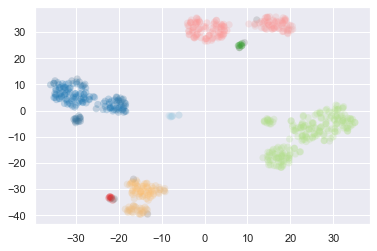

In [28]:
projection = TSNE().fit_transform(df_final)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

### Selección de parámetros

Se puede observar que existen clusters muy pequeños, pdoría mejorar el modelo si se incluyen esos valores en los clusters que tienen más cercanos

#### Selección min_cluster_size

Se probará cuál es el valor que genera mejor coeficiente de silueta

In [29]:
# Identificar el valor de min_cluster_size, utilizando ahora el valor de la silueta
def plot_select_size_silhoute(data,
                    size_min=5, 
                    size_max=105,
                    ylabel = 'Silhouette Coefficient',
                    xlabel = 'Min Clusters Size',
                    style = 'fivethirtyeight'):
    # Crear una lista para almacenar los coeficientes de la silueta para cada valor de k analizado

    silhouette_coefficients = []
    xticks = []
    
    k = size_min
    while k <= size_max:
        HDBSc = hdbscan.HDBSCAN(min_cluster_size=k)
        HDBSc.fit(data)
        score = silhouette_score(data, HDBSc.labels_)
        silhouette_coefficients.append(score)
        xticks.append(k)
        k += 10
    plt.style.use(style)
    plt.plot(xticks, silhouette_coefficients)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()    

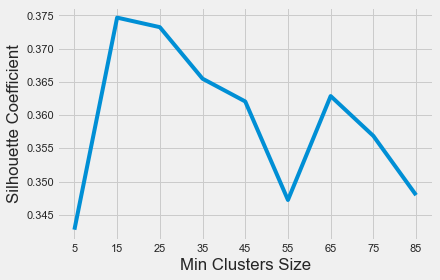

In [30]:
plot_select_size_silhoute(df_final, size_min=5, size_max=90)

El mejor valor reportado es de 15

#### Selección min_samples

Se probará cuál es el valor que genera mejor coeficiente de silueta

In [31]:
# Identificar el valor de min_cluster_size, utilizando ahora el valor de la silueta
def plot_select_samples_silhoute(data,
                    samples_min=1, 
                    samples_max=105,
                    ylabel = 'Silhouette Coefficient',
                    xlabel = 'Min Samples',
                    style = 'fivethirtyeight'):
    # Crear una lista para almacenar los coeficientes de la silueta para cada valor de k analizado

    silhouette_coefficients = []
    xticks = []
    
    k = samples_min
    while k <= samples_max:
        HDBSc = hdbscan.HDBSCAN(min_samples=k)
        HDBSc.fit(data)
        score = silhouette_score(data, HDBSc.labels_)
        silhouette_coefficients.append(score)
        xticks.append(k)
        k += 5
    plt.style.use(style)
    plt.plot(xticks, silhouette_coefficients)
    plt.xticks(xticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()    

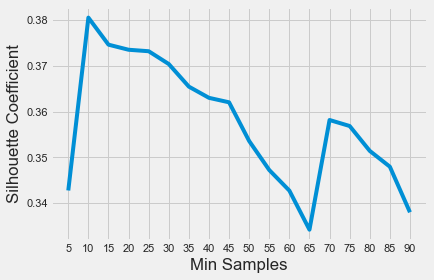

In [32]:
plot_select_samples_silhoute(df_final, samples_min=5, samples_max=90)

El mejor valor reportado es de 10

### Mejor modelo

Se utilizan los parámetros encontrados anteriormente

In [50]:
mejor_HDBSc = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10)
mejor_HDBSc.fit(df_final)
np.unique(mejor_HDBSc.labels_)

array([-1,  0,  1,  2,  3])

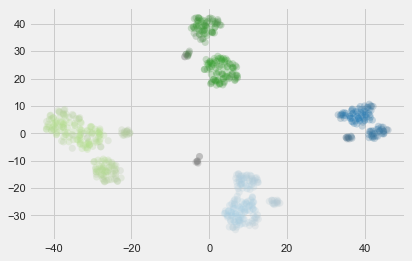

In [51]:
projection = TSNE().fit_transform(df_final)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in mejor_HDBSc.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, mejor_HDBSc.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [35]:
#Creamos una función basada en el concepto de silueta
def plot_silhouette(data, 
                    labels,
                   ylabel = 'Clústeres',
                   xlabel = "Silhouette coefficient",
                   title = 'Silhouette Plot'):
    '''
    Graficar la silueta de los clusters
    
    Parametros
    ----------
    data : np.array
        El arreglo con los datos
    labels : np.array
        El arreglo con las etiquetas correspondientes
    ylabel  string
        La etiqueta del eje y
    xlabel : string
        La etiqueta del eje x
    title : string
        El titulo de la gráfica        
    '''
    cluster_labels = np.unique(labels)
    cluster_labels = np.delete(cluster_labels,[0])
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,
                color="red",
                linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

[0 1 2 3]


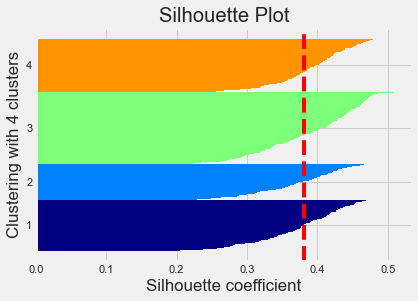

In [52]:
plot_silhouette(data = df_final, 
                labels = mejor_HDBSc.labels_, 
                ylabel = 'Clustering with 4 clusters')

In [63]:
#Transformar el contenido de las columnas a arreglo
cols_number = df_final.to_numpy()
df_final.columns

Index(['Limit_bal', 'Education', 'Age', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made',
       'is_male', 'Married', 'Other', 'Single'],
      dtype='object')

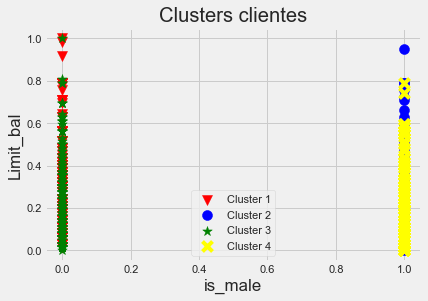

In [78]:
# Ver gráficamente los elementos de los diferentes clúster
plt.scatter(cols_number[mejor_HDBSc.labels_ == 0, 7], cols_number[mejor_HDBSc.labels_ == 0, 0], s = 100, marker='v', c = 'red', label = 'Cluster 1')
plt.scatter(cols_number[mejor_HDBSc.labels_ == 1, 7], cols_number[mejor_HDBSc.labels_ == 1, 0], s = 100, marker='o', c = 'blue', label = 'Cluster 2')
plt.scatter(cols_number[mejor_HDBSc.labels_ == 2, 7], cols_number[mejor_HDBSc.labels_ == 2, 0], s = 100, marker='*', c = 'green', label = 'Cluster 3')
plt.scatter(cols_number[mejor_HDBSc.labels_ == 3, 7], cols_number[mejor_HDBSc.labels_ == 3, 0], s = 100, marker='x', c = 'yellow', label = 'Cluster 4')

#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters clientes')
plt.xlabel(df_final.columns[7])
plt.ylabel(df_final.columns[0])
plt.legend()
plt.show()

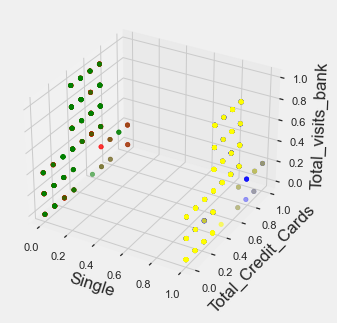

In [80]:
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(cols_number[mejor_HDBSc.labels_ == 0, 10], cols_number[mejor_HDBSc.labels_ == 0, 3], cols_number[mejor_HDBSc.labels_ == 0, 4],color='red')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 1, 10], cols_number[mejor_HDBSc.labels_ == 1, 3], cols_number[mejor_HDBSc.labels_ == 1, 4],color='green')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 2, 10], cols_number[mejor_HDBSc.labels_ == 2, 3], cols_number[mejor_HDBSc.labels_ == 2, 4],color='blue')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 3, 10], cols_number[mejor_HDBSc.labels_ == 3, 3], cols_number[mejor_HDBSc.labels_ == 3, 4],color='yellow')

#ax.scatter(mejor_HDBSc.cluster_centers_[:, 0],mejor_HDBSc.cluster_centers_[:, 1], mejor_HDBSc.cluster_centers_[:, 2], color='yellow',marker='o',s=200, label='centroids')
ax.set_xlabel(df_final.columns[10])
ax.set_ylabel(df_final.columns[3])
ax.set_zlabel(df_final.columns[4])
plt.show()

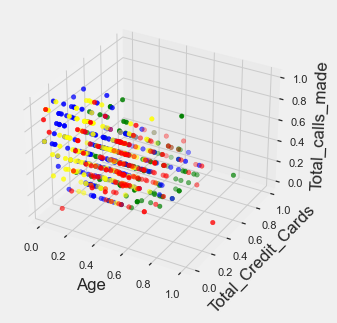

In [70]:
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(cols_number[mejor_HDBSc.labels_ == 0, 2], cols_number[mejor_HDBSc.labels_ == 0, 3], cols_number[mejor_HDBSc.labels_ == 0, 6],color='red')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 1, 2], cols_number[mejor_HDBSc.labels_ == 1, 3], cols_number[mejor_HDBSc.labels_ == 1, 6],color='green')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 2, 2], cols_number[mejor_HDBSc.labels_ == 2, 3], cols_number[mejor_HDBSc.labels_ == 2, 6],color='blue')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 3, 2], cols_number[mejor_HDBSc.labels_ == 3, 3], cols_number[mejor_HDBSc.labels_ == 3, 6],color='yellow')

#ax.scatter(mejor_HDBSc.cluster_centers_[:, 0],mejor_HDBSc.cluster_centers_[:, 1], mejor_HDBSc.cluster_centers_[:, 2], color='yellow',marker='o',s=200, label='centroids')
ax.set_xlabel(df_final.columns[2])
ax.set_ylabel(df_final.columns[3])
ax.set_zlabel(df_final.columns[6])
plt.show()

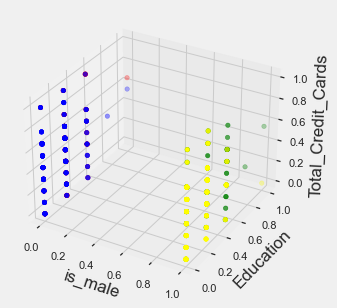

In [81]:
fig=plt.figure()
ax=Axes3D(fig)
ax.scatter(cols_number[mejor_HDBSc.labels_ == 0, 7], cols_number[mejor_HDBSc.labels_ == 0, 1], cols_number[mejor_HDBSc.labels_ == 0, 3],color='red')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 1, 7], cols_number[mejor_HDBSc.labels_ == 1, 1], cols_number[mejor_HDBSc.labels_ == 1, 3],color='green')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 2, 7], cols_number[mejor_HDBSc.labels_ == 2, 1], cols_number[mejor_HDBSc.labels_ == 2, 3],color='blue')
ax.scatter(cols_number[mejor_HDBSc.labels_ == 3, 7], cols_number[mejor_HDBSc.labels_ == 3, 1], cols_number[mejor_HDBSc.labels_ == 3, 3],color='yellow')

#ax.scatter(mejor_HDBSc.cluster_centers_[:, 0],mejor_HDBSc.cluster_centers_[:, 1], mejor_HDBSc.cluster_centers_[:, 2], color='yellow',marker='o',s=200, label='centroids')
ax.set_xlabel(df_final.columns[7])
ax.set_ylabel(df_final.columns[1])
ax.set_zlabel(df_final.columns[3])
plt.show()